In [1]:
"""
This script is to generate the enhanced Alpha9 strategy, which is the combination of Raw Alpha 9 and 
one event driven strategy Alpha1_7:
    - The Raw Alpha9 has been described in detail in the separate alpha9.ipynb 
    - Alpha1_7 is one event driven strategy, acting upon the arrival of valid values coming from 
      dataset1, 2, ..., 7. Very likely these 7 datasets are providing indicators to public company's 
      commonly followed KPIs such as top-line, bottom-line, EBITDA growths, right before the earning announcement 
"""

%matplotlib inline
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns

import sys
from scipy.stats import norm
sys.path.append('..') # Adds higher directory to python modules path.

print(f"Current working dir is {os.getcwd()}\n")

# Load utils functions
from math_trend import *
from utils import *

plt.rcParams['figure.figsize'] = [15, 7]
plt.style.use("ggplot")

# Settings
ROOT = '/home/jma/Python3.7/Cubist_2021_11' ### please make sure you change root before the run
PROCESSED_DATA_DIR = os.path.join(ROOT, 'processed_data')

in_sample_start_date = '2011-01-01'
in_sample_end_date = '2016-01-01'
print("There are 5 years' in-sample data, 2 years' out-of-sample data\n")

dtcol = 'pos_date'
seccol = 'security_id'

dscols = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']

## All 7 indicators seem to be related to earning announcements. 
## from Spearman rank correlation, d7 has negative IC with fwdretf1, similar magnituide as d9 
big_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'known_df_on_data_date.csv.gz'),
                     parse_dates=[dtcol], dtype={seccol: str}, 
                     usecols=[dtcol, seccol] + dscols + ['clip_trisk', 'fwdret_f1', 'sector', 'in_trading_universe'])

assert not big_df.duplicated(subset=[dtcol, seccol]).any(), f"There are duplicated {dtcol} and {seccol}!"

print("Getting the complete trading universe\n")
rsch_universe = big_df[[dtcol, seccol]].copy()

Current working dir is /home/jma/Python3.7/Cubist_2021_11/alphas

There are 5 years' in-sample data, 2 years' out-of-sample data

Getting the complete trading universe



<AxesSubplot:title={'center':'Daily number of stocks within trading universe'}, xlabel='pos_date'>

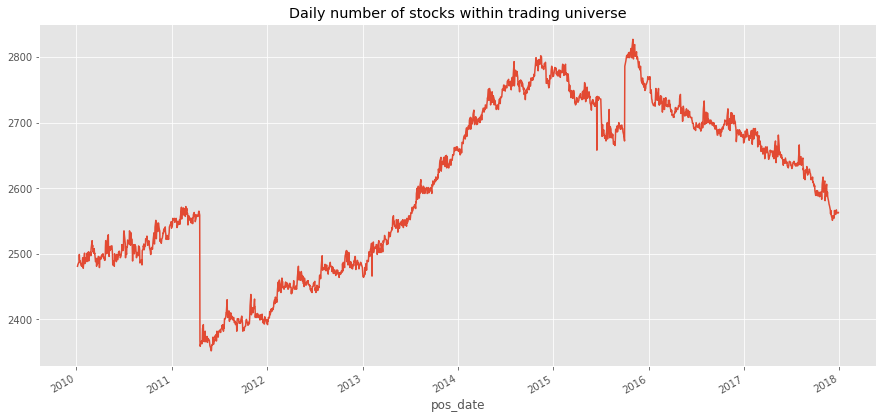

In [2]:
rsch_universe.groupby(dtcol).size().plot(title='Daily number of stocks within trading universe')

In [3]:
print(f"Dropping the rows with all NaNs values from {dscols}")
big_df.dropna(subset=dscols, how='all', inplace=True)
big_df.sort_values(by=[dtcol, seccol], inplace=True)

Dropping the rows with all NaNs values from ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7']


In [4]:
# print(big_df.head(), '\n')
print(f"big_df.tail():\n{big_df.tail()}\n\n")
print(f"big_df.shape:{big_df.shape}\n\n")
print(f"big_df descriptive stats:\n{big_df[dscols].describe()}")

big_df.tail():
        security_id       d1        d2        d3       d4        d5      d6  \
5223406     5464701   98.300   923.200  0.038511  18.2145  0.012644  0.9525   
5223532      597001   13.309    55.584  0.034698  13.1837  0.021558  0.5578   
5223828       78001    1.000   -20.100 -0.012298   1.9796 -0.020741  0.0655   
5223968     8386601  872.486  4330.280  0.047501  22.1053  0.016434  0.0925   
5225540     3538501  -23.224    37.843  0.028153 -52.7621 -0.443291 -0.8603   

             d7   pos_date  fwdret_f1 in_trading_universe  \
5223406 -0.1531 2017-12-26  -0.006536                   Y   
5223532 -0.0714 2017-12-26  -0.003113                   Y   
5223828  0.0093 2017-12-26  -0.012453                   Y   
5223968 -0.2605 2017-12-26   0.002157                   Y   
5225540 -0.5744 2017-12-27   0.046875                   N   

                         sector  clip_trisk  
5223406  Information Technology   14.661838  
5223532             Industrials   28.930722  
52238

Plotting out daily number stocks covered by at least 1 out of the 7 datasets


<AxesSubplot:xlabel='pos_date'>

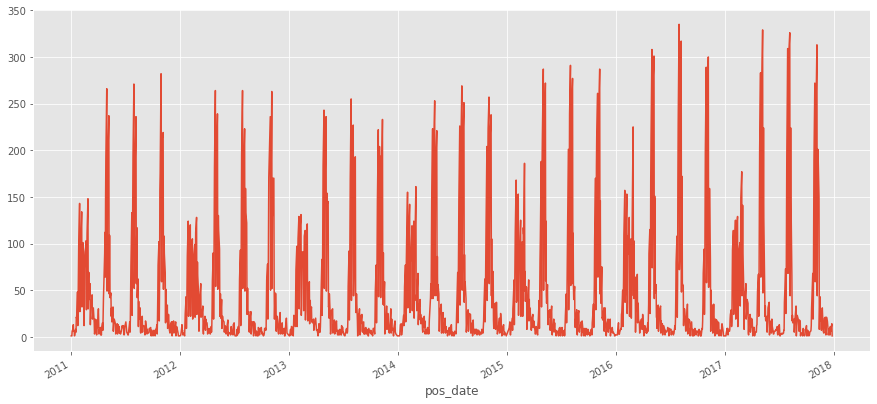

In [5]:
print("Plotting out daily number stocks covered by at least 1 out of the 7 datasets")
big_df.loc[big_df[dtcol] >= in_sample_start_date].groupby(dtcol).size().plot()

In [6]:
big_df[dscols + ['fwdret_f1']].corr(method='spearman').sort_values(by=['fwdret_f1'], ascending=False).round(4)

d1      d2      d3      d4      d5      d6      d7  fwdret_f1
fwdret_f1  0.0379  0.0231  0.0244  0.0114  0.0261 -0.0177 -0.0146     1.0000
d1         1.0000  0.6903  0.5280  0.3066  0.3547 -0.0855 -0.1019     0.0379
d5         0.3547  0.3778  0.4781  0.6137  1.0000  0.0822  0.0645     0.0261
d3         0.5280  0.7356  1.0000  0.4254  0.4781 -0.2108 -0.2538     0.0244
d2         0.6903  1.0000  0.7356  0.4075  0.3778 -0.1310 -0.1401     0.0231
d4         0.3066  0.4075  0.4254  1.0000  0.6137  0.1744  0.0522     0.0114
d7        -0.1019 -0.1401 -0.2538  0.0522  0.0645  0.3914  1.0000    -0.0146
d6        -0.0855 -0.1310 -0.2108  0.1744  0.0822  1.0000  0.3914    -0.0177

Plot out daily number of stocks for each sector


array([<AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>, <AxesSubplot:xlabel='pos_date'>,
       <AxesSubplot:xlabel='pos_date'>], dtype=object)

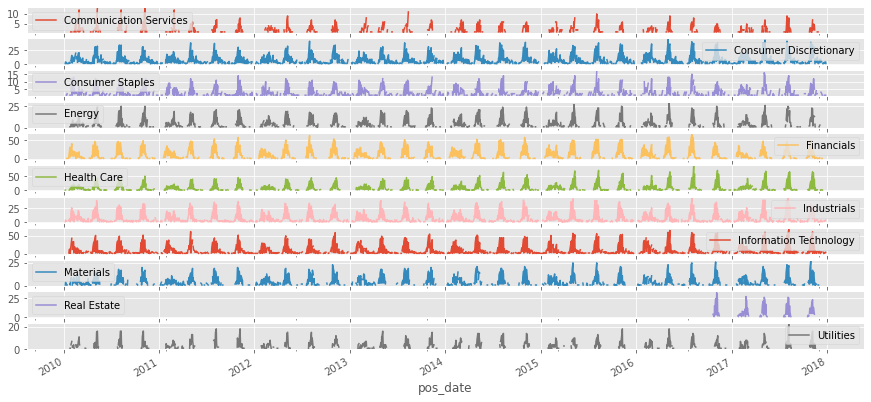

In [7]:
print("Plot out daily number of stocks for each sector")
big_df.groupby(['pos_date', 'sector']).size().unstack(level=1).plot(subplots=True)

In [8]:
print(big_df.isnull().sum())
print(big_df.shape)

security_id                0
d1                      2478
d2                      8099
d3                     13156
d4                      2475
d5                      6021
d6                     12496
d7                     12031
pos_date                   0
fwdret_f1                  8
in_trading_universe        0
sector                     0
clip_trisk              3094
dtype: int64
(86049, 13)


In [9]:
# each earning period almost covers all tradable securities 
print("Count the number of records within last quarter, this implies good chance of earning print related data")
len(big_df.loc[big_df[dtcol] >= '2017-10-01', seccol].unique())

Count the number of records within last quarter, this implies good chance of earning print related data


2744

In [10]:
big_df = big_df.loc[(big_df['in_trading_universe'] == 'Y') & (big_df[dtcol] >= in_sample_start_date)]

In [11]:
print("big_df.head():\n", big_df.head(), "\n\n")
print("big_df.tail():\n", big_df.tail(), "\n\n")

big_df.head():
        security_id       d1        d2        d3       d4        d5      d6  \
638574     4834101  240.700  1027.200  0.036884  14.9093  0.023635  0.0352   
639114     7040301   20.847    58.591  0.053532   8.5600  0.016256 -0.0772   
640356     2539201  -79.138   340.286  0.052217  21.3572  0.018657  0.0421   
641536     6088601    3.418    93.777  0.084221   7.5465  0.007027 -0.0500   
642061     8262901   54.980   -57.596 -0.037450   2.8802  0.008403  0.1522   

            d7   pos_date  fwdret_f1 in_trading_universe  \
638574 -0.0207 2011-01-06  -0.017135                   Y   
639114 -0.1092 2011-01-06  -0.015192                   Y   
640356 -0.1392 2011-01-07   0.000911                   Y   
641536 -0.0693 2011-01-07  -0.003369                   Y   
642061  0.0906 2011-01-07   0.005268                   Y   

                        sector  clip_trisk  
638574               Materials   41.182594  
639114  Consumer Discretionary   37.802583  
640356  Consumer Di

In [12]:
print("Counting number of valid scores within each sector:\n\n", big_df.groupby('sector')[dscols].apply(lambda x: x.notnull().sum()))

Counting number of valid scores within each sector:

                           d1    d2    d3    d4    d5    d6    d7
sector                                                          
Communication Services   767   635   625   775   781   767   768
Consumer Discretionary  7795  7340  7327  7868  7977  7656  7676
Consumer Staples        2263  2149  2127  2230  2241  2220  2220
Energy                  3643  3295  3175  3577  3523  3570  3573
Financials              9345  8780  6366  9603  6791  5081  5088
Health Care             6268  6031  6020  6226  6296  6164  6174
Industrials             6902  6682  6654  6886  6959  6799  6811
Information Technology  8533  8244  8215  8696  8810  8269  8372
Materials               3502  3240  3233  3480  3497  3471  3475
Real Estate              734   711   705   729   731   721   724
Utilities               1960  1865  1861  1952  1969  1950  1952


In [13]:

print(f"Loading the generated combined_score from dataset_9")
si_sigs = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'original_alpha9.csv.gz'), 
                    parse_dates=['pos_date'], 
                    dtype={'security_id': str},
                    compression='gzip')
print(si_sigs)

Loading the generated combined_score from dataset_9
          pos_date security_id  clip_trisk  fwdret_f1                  sector  \
0       2011-01-03     1004601   62.162621  -0.020927  Information Technology   
1       2011-01-03      100701   19.749199  -0.009325               Utilities   
2       2011-01-03     1007201   37.389405  -0.011587  Consumer Discretionary   
3       2011-01-03     1009601   29.017306  -0.029014        Consumer Staples   
4       2011-01-03    10116101   55.507777   0.007392             Industrials   
...            ...         ...         ...        ...                     ...   
3162239 2017-12-28      968101   14.160296  -0.008243              Financials   
3162240 2017-12-28       97801   13.593583  -0.005100              Financials   
3162241 2017-12-28      985601   30.191535  -0.013173  Consumer Discretionary   
3162242 2017-12-28      995201   24.067018  -0.008429        Consumer Staples   
3162243 2017-12-28      996501   17.550179  -0.004859    

pos_date
2016-08-01    267
2017-07-31    265
2016-05-02    248
2017-05-01    247
2017-11-06    242
             ... 
2017-02-01     30
2015-02-03     30
2015-07-22     30
2012-10-24     30
2013-08-07     30
Length: 482, dtype: int64


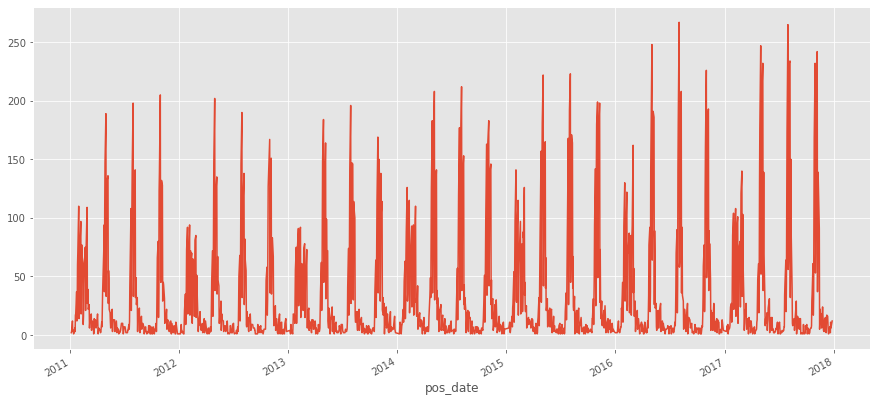

In [14]:

## threshold want to have at least 50 stocks carry signal values, otherwise might not able to guarantee 
## cross-sectional normalization mathematically soundness 
threshold_n = 30
ncount = big_df.groupby(dtcol).size()
ncount.plot()
ncount = ncount[ncount >= threshold_n]
print(ncount.sort_values(ascending=False))

<AxesSubplot:xlabel='pos_date'>

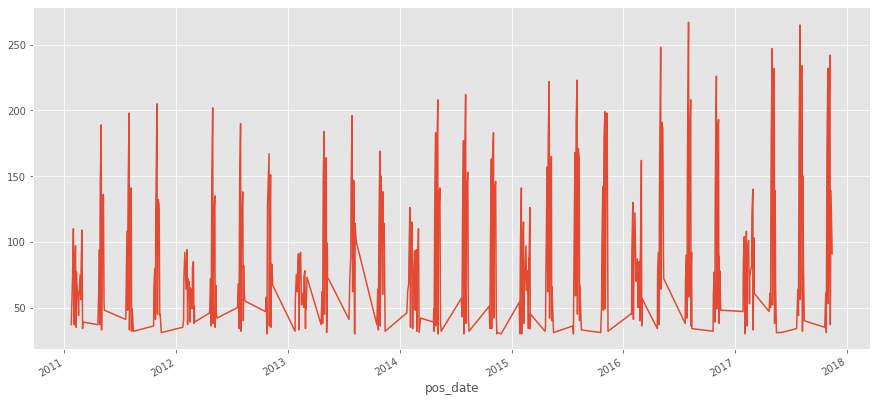

In [15]:
big_df = big_df.loc[big_df[dtcol].isin(ncount.index)]
big_df.groupby(dtcol).size().plot()

In [16]:
for col in dscols:
    print(f" Ranking scorecol {col}...")
    big_df[f'{col}_rank'] = big_df.groupby(dtcol)[col].rank()
    big_df[f'{col}_rank_scale'] = big_df.groupby(dtcol)[f'{col}_rank'].transform(lambda x: x / (len(x) + 1))
    big_df[f'{col}_rank_score'] = norm.ppf(big_df[f'{col}_rank_scale'].values)

 Ranking scorecol d1...
 Ranking scorecol d2...
 Ranking scorecol d3...
 Ranking scorecol d4...
 Ranking scorecol d5...
 Ranking scorecol d6...
 Ranking scorecol d7...


In [17]:
final_alpha_cols = ['d1_rank_score', 'd2_rank_score', 'd3_rank_score', 'd4_rank_score',
                  'd5_rank_score', 'd6_rank_score', 'd7_rank_score']

In [18]:
score_df = big_df[['pos_date', 'security_id', 'fwdret_f1', 'in_trading_universe', 'sector', 'clip_trisk'] + 
                  final_alpha_cols].copy()
print(score_df.head())

         pos_date security_id  fwdret_f1 in_trading_universe  \
665419 2011-01-24     1221001  -0.005364                   Y   
665507 2011-01-24     1468301   0.001025                   Y   
665575 2011-01-24     1666001   0.001978                   Y   
665622 2011-01-24     1799901   0.013369                   Y   
665784 2011-01-24     2369301   0.007463                   Y   

                        sector  clip_trisk  d1_rank_score  d2_rank_score  \
665419              Financials   35.115179      -0.716498       1.619856   
665507              Financials   30.167862       0.266994       0.199201   
665575               Utilities   19.498901       1.003148      -0.066012   
665622             Health Care   26.967702       0.199201      -0.266994   
665784  Information Technology   36.495834      -0.804596      -1.252120   

        d3_rank_score  d4_rank_score  d5_rank_score  d6_rank_score  \
665419       0.406724      -0.479506      -0.804596      -1.252120   
665507            

In [19]:
score_df[final_alpha_cols] = score_df[final_alpha_cols].fillna(0)

In [20]:
print("Splitting Alpha1_7 into in-sample and out-of-sample period")
in_sample_scoredf = score_df[score_df['pos_date'].between(in_sample_start_date, in_sample_end_date)].copy()
out_of_sample_df = score_df[score_df['pos_date'] >= in_sample_end_date].copy()

Splitting Alpha1_7 into in-sample and out-of-sample period


Computing the Spearman ranking correlation between final_alphas and forward 1 day's return 


Text(0.5, 0, "Correlation coefficient between score and forward 1 day's return")

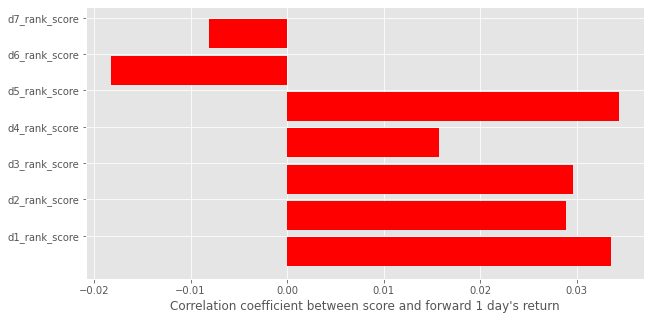

In [21]:
print("Computing the Spearman ranking correlation between final_alphas and forward 1 day's return ")

labels = []
values = []
for col in final_alpha_cols:
    labels.append(col)
    values.append(in_sample_scoredf[[col, 'fwdret_f1']].corr(method='spearman').iloc[0, 1])
    
## Looks like the prediction power of d9 is the best 
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10, 5))
rects = ax.barh(ind, np.array(values), color='r')
ax.set_yticks(ind + (width / 2.0))
ax.set_yticklabels(labels, rotation='horizontal')
# ax.set_yticklabels(rotation='45')
ax.set_xlabel("Correlation coefficient between score and forward 1 day's return")

## Since datasets 1 to 7 are very likely to bet on earning prints, maybe topline/bottomline beat or miss, revenue growth, or other KPI dynamics, so I think there are fundamental related dataset, so no need to further split in sample data into train and test. From 2011 to 2016, ds 1, 2, 3 and 5 showed consistent annualized return for every year, highest cumulative return and highest IC, so I choose the equal weighted version as the 4 rank_score signals

## Creating Enhanced Alpha9 below

In [22]:
use_scores  = ['d1_rank_score', 'd2_rank_score', 'd3_rank_score', 'd5_rank_score']
print(f"I choose len(use_score) scores for Alpha1_7 generation, which are {use_scores}")

I choose len(use_score) scores for Alpha1_7 generation, which are ['d1_rank_score', 'd2_rank_score', 'd3_rank_score', 'd5_rank_score']


In [23]:
print(f"Alpha1_7 is the simple average among {use_scores}")
score_df = score_df[[dtcol, seccol] + use_scores]
score_df['Alpha1_7'] = score_df[use_scores].mean(axis=1)

Alpha1_7 is the simple average among ['d1_rank_score', 'd2_rank_score', 'd3_rank_score', 'd5_rank_score']


In [24]:
print(score_df.head())
print(score_df.tail())

         pos_date security_id  d1_rank_score  d2_rank_score  d3_rank_score  \
665419 2011-01-24     1221001      -0.716498       1.619856       0.406724   
665507 2011-01-24     1468301       0.266994       0.199201       0.000000   
665575 2011-01-24     1666001       1.003148      -0.066012      -1.412188   
665622 2011-01-24     1799901       0.199201      -0.266994       0.554923   
665784 2011-01-24     2369301      -0.804596      -1.252120      -0.554923   

        d5_rank_score  Alpha1_7  
665419      -0.804596  0.126372  
665507       0.000000  0.116549  
665575      -0.406724 -0.220444  
665622       0.554923  0.260513  
665784      -1.937932 -1.137393  
          pos_date security_id  d1_rank_score  d2_rank_score  d3_rank_score  \
5149328 2017-11-13     7521601       0.333005      -0.247724       0.109200   
5149355 2017-11-13     7636701      -1.843765       0.000000       0.000000   
5149356 2017-11-13     7639301       0.744586       0.481115      -0.219723   
5149371 201

In [25]:
print("Outer joining original Alpha9 and Alpha1_7")
enhanced_df = pd.merge(si_sigs, 
                       score_df[[dtcol, seccol] + ['Alpha1_7']], 
                       on=[dtcol, seccol], how='left')

Outer joining original Alpha9 and Alpha1_7


In [26]:
enhanced_df['enhanced'] = enhanced_df[['combined_score', 'Alpha1_7']].mean(axis=1)

In [27]:
enhanced_df['enhanced_score'] = std_qnt_score(enhanced_df, 'enhanced', 'pos_date', demean=True)
enhanced_df['enhanced_score'] = enhanced_df['enhanced_score'].clip(-3, 3)

Running analyzer for Original Alpha9:

Running analyzer for Enhanced Alpha9:



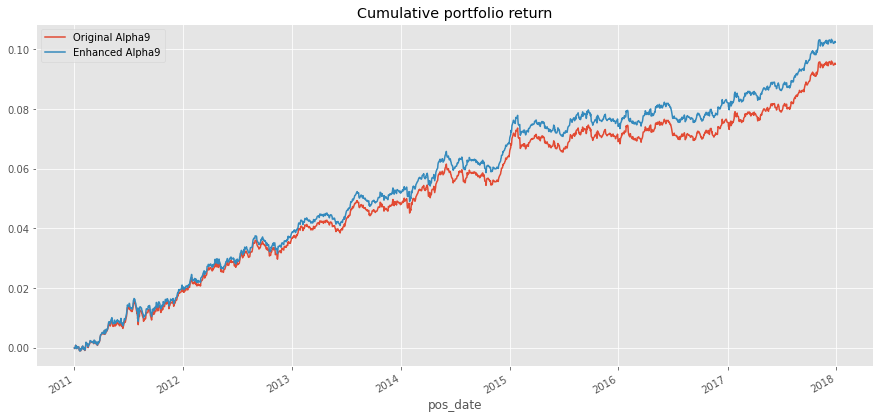

In [28]:
print("Running analyzer for Original Alpha9:\n")
daily_return_raw, ann_stats_raw = \
    quickstats(enhanced_df, 'combined_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

print("Running analyzer for Enhanced Alpha9:\n")
daily_return_enhanced, ann_stats_enhanced = \
    quickstats(enhanced_df, 'enhanced_score', 'clip_trisk', riskpower=2, retcol='fwdret_f1', dtcol='pos_date', seccol='security_id')

plt.legend(['Original Alpha9', 'Enhanced Alpha9'], loc='upper left')

In [29]:
print(ann_stats_raw)
print(ann_stats_enhanced)

      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0201  0.0115  252.0  1.7550   1585  0.2215
2012  0.0164  0.0089  250.0  1.8397   1523  0.2270
2013  0.0114  0.0075  252.0  1.5288   1686  0.2202
2014  0.0166  0.0097  252.0  1.7081   1926  0.2328
2015  0.0045  0.0101  252.0  0.4476   1947  0.2249
2016  0.0066  0.0089  252.0  0.7332   1912  0.2156
2017  0.0195  0.0090  250.0  2.1612   1994  0.2131
      AnnRet  AnnVol   Days   AnnSR  Count   AnnTO
year                                              
2011  0.0210  0.0116  252.0  1.8184   1585  0.2325
2012  0.0174  0.0090  250.0  1.9385   1523  0.2379
2013  0.0134  0.0075  252.0  1.7933   1686  0.2317
2014  0.0171  0.0098  252.0  1.7505   1926  0.2435
2015  0.0053  0.0101  252.0  0.5274   1947  0.2364
2016  0.0080  0.0089  252.0  0.9028   1912  0.2269
2017  0.0202  0.0091  250.0  2.2270   1994  0.2246


In [30]:
print("Calc Yearly MaxDD and the Length")

print(daily_return_enhanced.head())
daily_return_enhanced['year'] = daily_return_enhanced['pos_date'].dt.year
print(daily_return_enhanced.groupby('year').apply(lambda x: calc_drawdown(x.set_index("pos_date")['attr_fwdretf1'])), "\n")
print("Max Drawdown of all times:\n", calc_drawdown(daily_return_enhanced.set_index("pos_date")['attr_fwdretf1']))

Calc Yearly MaxDD and the Length
    pos_date  attr_fwdretf1
0 2011-01-03      -0.000092
1 2011-01-04      -0.000159
2 2011-01-05       0.000071
3 2011-01-06       0.000126
4 2011-01-07       0.000872
      Max_Drawdown  Length
year                      
2011        -0.008    10.0
2012        -0.006    50.0
2013        -0.005    30.0
2014        -0.007    93.0
2015        -0.007   105.0
2016        -0.007    67.0
2017        -0.003    16.0 

Max Drawdown of all times:
 Max_Drawdown    -0.008
Length          10.000
dtype: float64


In [31]:
print("Compute % of positive portfolio return days for each year:")
daily_return_enhanced.loc[daily_return_enhanced['year'] >= 2011].groupby('year')['attr_fwdretf1'].apply(
    lambda x: round((x > 0).sum() / len(x) * 100, 2))

Compute % of positive portfolio return days for each year:


year
2011    56.35
2012    57.20
2013    55.16
2014    59.13
2015    53.97
2016    51.19
2017    55.60
Name: attr_fwdretf1, dtype: float64